In [1]:
import numpy as np
import random
import math
from tqdm.notebook import tqdm
import pandas as pd
import torch
import torch.nn.functional as F
from gym import spaces
import matplotlib.pyplot as plt
from dataclasses import dataclass

/Users/valentinbrekke/miniconda3/lib/python3.10/site-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


In [2]:
from env import *
from SAC import *

In [3]:
env_param = dict(a=0.5, 
                T=10, 
                k=0.1, 
                Ux=1, 
                Uy=1, 
                alpha=1, 
                sigma=0.1, 
                x_goal=4, 
                y_goal=4, 
                pos0=np.array([0, 0, 0]), 
                theta0=0, 
                dist_threshold=0.2, 
                max_steps=200,
                ocean=True,
                dt=1,
                max_thrust_speed=5,
                )

env = FluidMechanicsEnv(**env_param)

/Users/valentinbrekke/miniconda3/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [19]:
@dataclass
class Args:
    
    seed: int = 1
    """seed of the experiment"""
    torch_deterministic: bool = True
    """if toggled, `torch.backends.cudnn.deterministic=False`"""
    cuda: bool = True
    """if toggled, cuda will be enabled by default"""
    # Algorithm specific arguments
    total_timesteps: int = 100000
    """total timesteps of the experiments"""
    buffer_size: int = int(1e6)
    """the replay memory buffer size"""
    gamma: float = 0.99
    """the discount factor gamma"""
    tau: float = 0.005
    """target smoothing coefficient (default: 0.005)"""
    batch_size: int = 256
    """the batch size of sample from the reply memory"""
    learning_starts: int = 25000
    """timestep to start learning"""
    policy_lr: float = 3e-4
    """the learning rate of the policy network optimizer"""
    q_lr: float = 1e-3
    """the learning rate of the Q network network optimizer"""
    policy_frequency: int = 2
    """the frequency of training policy (delayed)"""
    target_network_frequency: int = 1  # Denis Yarats' implementation delays this by 2.
    """the frequency of updates for the target nerworks"""
    alpha: float = 0.2
    """Entropy regularization coefficient."""
    autotune: bool = True
    """automatic tuning of the entropy coefficient"""
    print_reward: bool = True
    """print the smooth reward after each epoch during training"""

In [5]:

# Seed everything for reproducibility
args = Args()
args.print_reward = True
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.backends.cudnn.deterministic = args.torch_deterministic

# Create and train SAC agent
sac_agent = SAC(env, args)

policy, t, episode_num, smooth_reward, execution_time = sac_agent.train()


KeyboardInterrupt: 

In [11]:
execution_time/60

0.7304000655810038

In [22]:
def plot_trajectory(policy):
    done = False
    obs = env.reset()
    x, y = [obs[0]], [obs[1]]

    while not done: 
        actions, _, _ = policy.get_action(torch.Tensor(obs).unsqueeze(0))
        actions = actions.detach().cpu().numpy()
        next_obs, rewards, sum_reward, terminations, steps_count, all_actions, = env.step(actions[0])
        x.append(next_obs[0])
        y.append(next_obs[1])
        obs = next_obs
        done = terminations
       
    fig = plt.figure(figsize = (10, 5))
    plt.grid(True)
    plt.scatter([env.x_goal], [env.y_goal], marker = "o", color = "r")
    plt.plot(x, y, 'k-o')
    plt.show()

def plot_reward(smooth_reward):
    # Plot cumulative rewards
    plt.figure(figsize=(10, 5))
    plt.plot(smooth_reward)
    plt.title("SAC - Cumulative Rewards Over Episodes")
    plt.xlabel("Episodes")
    plt.ylabel("Cumulative Reward")
    plt.grid(True)
    plt.show()

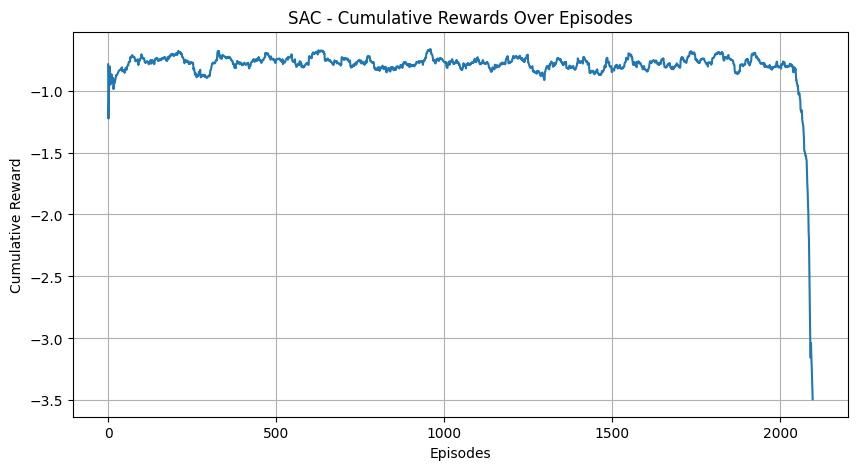

In [23]:
plot_reward(smooth_reward)

In [14]:
plot_trajectory(policy)

NameError: name 'policy' is not defined

## Run multiple instance with seeds

seed: 0, Total steps: 100000, Num episodes: 5706, execution_time : 563.4405927658081


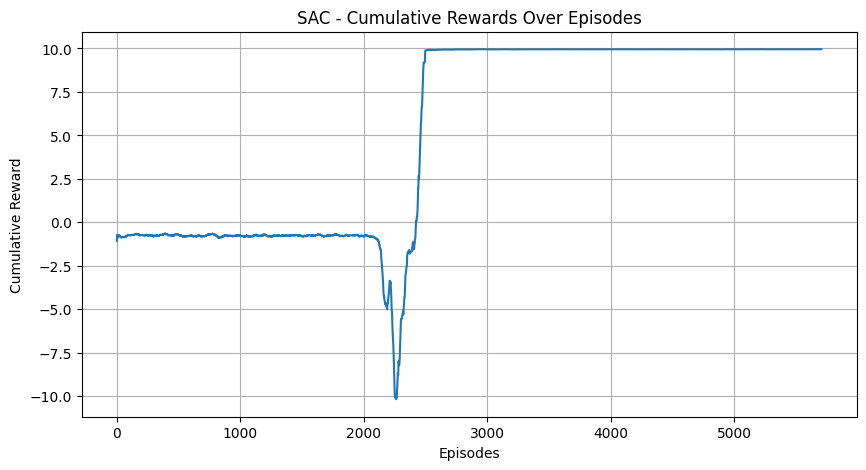

seed: 1, Total steps: 100000, Num episodes: 5579, execution_time : 558.6439371109009


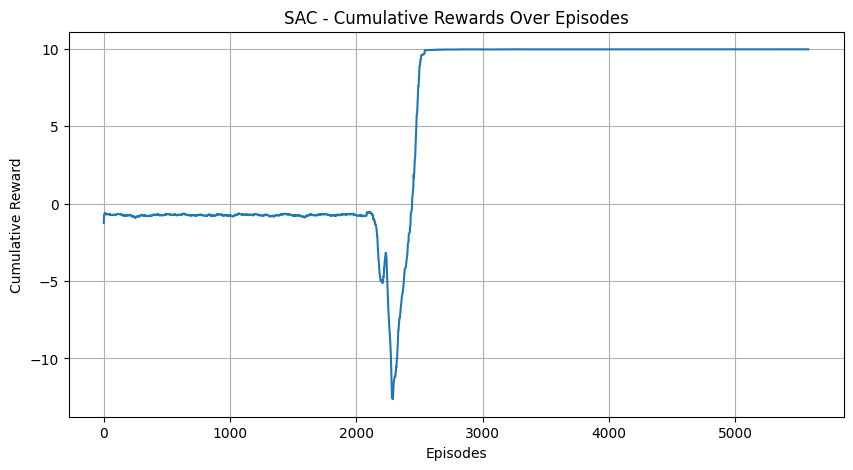

seed: 2, Total steps: 100000, Num episodes: 4073, execution_time : 1618.981171131134


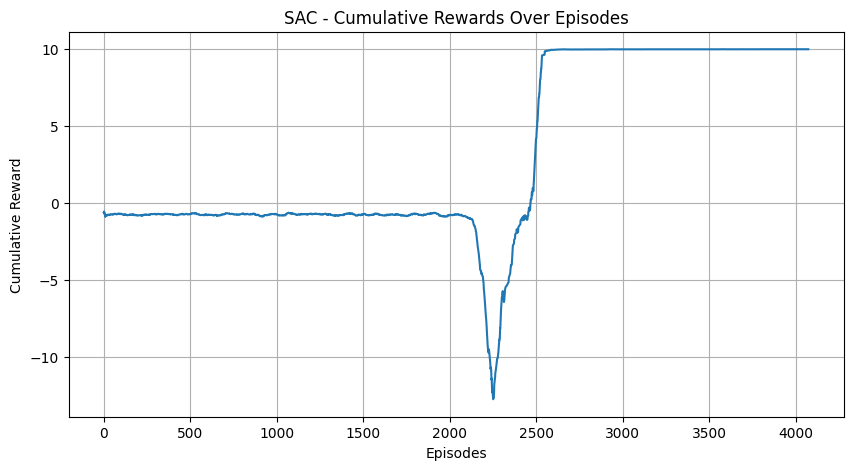

seed: 3, Total steps: 100000, Num episodes: 5360, execution_time : 481.23914408683777


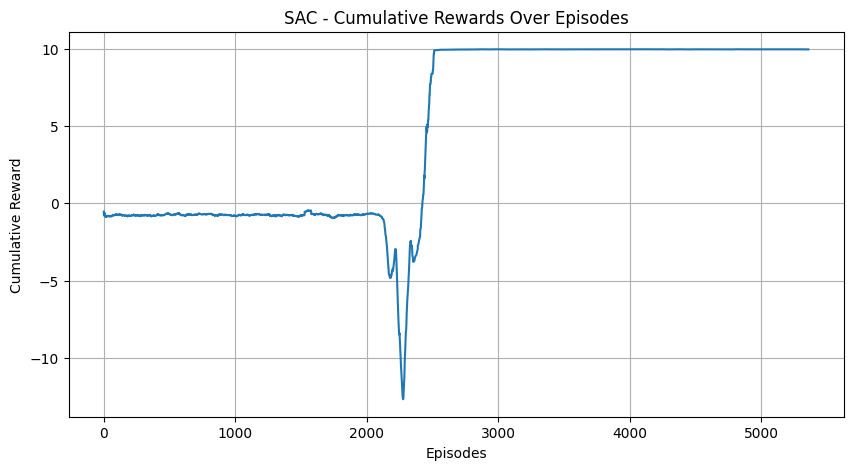

seed: 4, Total steps: 100000, Num episodes: 5725, execution_time : 472.83294892311096


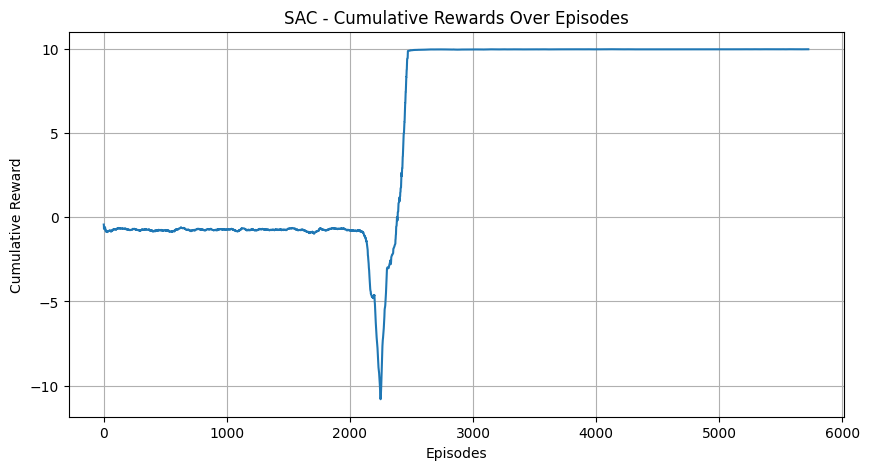

In [24]:
import json

reward_dict = dict()
#### Train and save the actor model
for seed in range(5):
        # Seed everything for reproducibility
        args = Args()
        args.seed = seed
        args.print_reward = False
        random.seed(args.seed)
        np.random.seed(args.seed)
        torch.manual_seed(args.seed)
        if args.cuda:
                torch.backends.cudnn.deterministic = args.torch_deterministic

        # Create and train SAC agent
        sac_agent = SAC(env, args)
        model, t, episode_num, smooth_reward, execution_time = sac_agent.train()

        print(f"seed: {seed}, Total steps: {t}, Num episodes: {episode_num}, execution_time : {execution_time}")
        reward_dict[seed] = smooth_reward
         
        if seed == 0:
                torch.save(model.state_dict(), "saved/SAC_seed0_wave05.pth")

        # #### Plot smooth reward
        plot_reward(smooth_reward)

        #### Sample a trajectory 
        # trajectory, total_reward = sample_trajectory(env, policy, env.max_steps)
        # print("Total reward from sampled trajectory:", total_reward)
        # plot_trajectory(trajectory)
with open('saved/SAC_05.txt', 'w') as convert_file: 
     convert_file.write(json.dumps(reward_dict))